# INTRODUCCION

El siguiente proyecto consiste en asesorar a la compañía de telecomunicaciones Interconnect sobre la creación de un modelo predictivo de la tasa de cancelación de clientes, de tal forma de que la compañía pueda anticiparse para ofrecer códigos promocionlaes y opciones de planes especiales. 

Para ello se utilizaran bases de datos facilitadas por el equipo de marketing de Interconnect que recopila datos desde el 2016 en adelante.
Se debe considerar que la información del contrato es válida a partir del 1 de febrero de 2020.

## Inicialización

In [1]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score

## Carga de datos

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Análisis exploratorio de datos

In [3]:
contract.info() #Verificamos los campos a nivel general de 'contract'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Glosario de dataset 'contract':

* customerID - ID del cliente (clave para unir datasets).
* BeginDate - Fecha de inicio del contrato (puede ayudar a calcular la duración del contrato).
* EndDate - Fecha de fin del contrato (puede ayudar a determinar si un contrato ha finalizado recientemente).
* Type - Tipo de contrato (mensual, 1 año, 2 años), importante para entender la fidelidad del cliente.
* PaperlessBilling - Facturación electrónica (puede influir en la satisfacción del cliente).
* PaymentMethod - Método de pago (algunos métodos pueden estar asociados con una mayor probabilidad de churn).
* MonthlyCharges - Cobro mensual (importante para entender la carga financiera sobre el cliente).
* TotalCharges - Cobro total (puede reflejar el valor del cliente a lo largo del tiempo).

In [4]:
contract.tail(4) #Vemos una muestra

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5


In [5]:
#Verificamos duplicidad
duplicados1 = contract.duplicated()
cantidad_duplicados1 = duplicados1.sum()
cantidad_duplicados1 # Finalmente, comprobamos el número de filas duplicadas de 'contract'

0

A continuacion procedemos a revisar los posibles errores y/o anomalías de cada variable de 'contract'.

In [6]:
contract['BeginDate'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en las fechas.

array(['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
       '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
       '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
       '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
       '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
       '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
       '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
       '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
       '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
       '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
       '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
       '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
       '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
       '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-

In [7]:
# Se indica que la información del contrato es valida desde el '2020-02-01' por lo que verificamos cuantos casos hay.
count_feb_1 = (contract['BeginDate'] == '2020-02-01').sum() 
print(f"Number of '2020-02-01' dates: {count_feb_1}")

Number of '2020-02-01' dates: 11


In [8]:
contract['EndDate'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en las fechas.

array(['2019-10-01 00:00:00', '2019-11-01 00:00:00',
       '2019-12-01 00:00:00', '2020-01-01 00:00:00', 'No'], dtype=object)

In [9]:
# Creamos la variable objetivo en una nueva columna, ya que es clave para el análisis.
contract['ContractStatus'] = contract['EndDate'].apply(lambda x: 1 if x == 'No' else 0)

# Verificamos el resultado
print(contract[['EndDate', 'ContractStatus']].head())

               EndDate  ContractStatus
0                   No               1
1                   No               1
2  2019-12-01 00:00:00               0
3                   No               1
4  2019-11-01 00:00:00               0


In [10]:
contract['Type'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en los datos.

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [11]:
contract['PaperlessBilling'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en los datos.

array(['No', 'Yes'], dtype=object)

In [12]:
contract['PaymentMethod'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en los datos.

array(['Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'], dtype=object)

In [13]:
personal.info() #Verificamos los campos a nivel general de 'personal'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Glosario para dataset 'personal':

* customerID - ID del cliente.
* gender - Género (podría tener alguna correlación con la tasa de cancelación, aunque debe analizarse cuidadosamente para evitar sesgos).
* SeniorCitizen - Indicador de si el cliente es ciudadano senior (los clientes mayores pueden tener diferentes patrones de comportamiento).
* Partner - Si el cliente tiene pareja (puede influir en la estabilidad del cliente con el servicio).
* Dependents - Si el cliente tiene dependientes (podría influir en la decisión de cancelar el servicio).

In [14]:
personal.head(4)  # Vemos una muestra

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No


In [15]:
#Verificamos duplicidad
duplicados2 = personal.duplicated()
cantidad_duplicados2 = duplicados2.sum()
cantidad_duplicados2 # Finalmente, comprobamos el número de filas duplicadas de 'personal'

0

A continuacion procedemos a revisar los posibles errores y/o anomalías de cada variable de 'personal'.

In [16]:
personal['gender'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en los datos.

array(['Female', 'Male'], dtype=object)

In [17]:
personal['SeniorCitizen'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en los datos.

array([0, 1])

In [18]:
personal['Partner'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en los datos.

array(['No', 'Yes'], dtype=object)

In [19]:
personal['Dependents'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en los datos.

array(['No', 'Yes'], dtype=object)

In [20]:
internet.info() #Verificamos los campos a nivel general de 'internet'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Glosario del dataset 'internet':
    
* customerID: ID del cliente.
* InternetService: Servicios de internet a través de línea telefónica (DSL, línea de abonado digital) o a través de un cable de fibra óptica.
* OnlineSecurity: Si tiene o no servicio de bloqueador de sitios web maliciosos
* OnlineBackup: Si tiene o no el servicio de almacenamiento y back up de datos.
* DeviceProtection: Si tiene el servicio o no de antivirus.
* TechSupport: Si tiene servicio de soporte técnico.
* StreamingTV: Si tiene o no servicio de TV.
* StreamingMovies: Si tiene o no servicio de directorio de peliculas.

In [24]:
internet.tail(4) #Vemos una muestra

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


In [26]:
#Verificamos duplicidad
duplicados3 = internet.duplicated()
cantidad_duplicados3 = duplicados3.sum()
cantidad_duplicados3 # Finalmente, comprobamos el número de filas duplicadas de 'internet'

0

In [27]:
internet.describe() # Vemos si hay anomalías en los valores numéricos de 'internet'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1480-BKXGA,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


A continuacion procedemos a revisar los posibles errores y/o anomalías de cada variable de 'internet'.

In [28]:
internet['InternetService'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en servicio de internet.

array(['DSL', 'Fiber optic'], dtype=object)

In [29]:
internet['OnlineSecurity'].sort_values(ascending=True).unique() # Verificamos posibles anomalías.

array(['No', 'Yes'], dtype=object)

In [30]:
internet['OnlineBackup'].sort_values(ascending=True).unique() # Verificamos posibles anomalías.

array(['No', 'Yes'], dtype=object)

In [31]:
internet['DeviceProtection'].sort_values(ascending=True).unique() # Verificamos posibles anomalías.

array(['No', 'Yes'], dtype=object)

In [32]:
internet['TechSupport'].sort_values(ascending=True).unique() # Verificamos posibles anomalías.

array(['No', 'Yes'], dtype=object)

In [33]:
internet['StreamingTV'].sort_values(ascending=True).unique() # Verificamos posibles anomalías.

array(['No', 'Yes'], dtype=object)

In [34]:
internet['StreamingMovies'].sort_values(ascending=True).unique() # Verificamos posibles anomalías.

array(['No', 'Yes'], dtype=object)

In [25]:
phone.info() #Verificamos los campos a nivel general de 'phone'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Glosario dataset 'phone': 

* customerID - ID del cliente.
* MultipleLines - Indicador de si el cliente tiene múltiples líneas telefónicas (puede ser relevante para entender la complejidad del servicio contratado).

In [26]:
phone.head()  #Vemos una muestra

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [35]:
#Verificamos duplicidad
duplicados4 = phone.duplicated()
cantidad_duplicados4 = duplicados4.sum()
cantidad_duplicados4 # Finalmente, comprobamos el número de filas duplicadas de 'phone'

0

A continuacion procedemos a revisar los posibles errores y/o anomalías de cada variable de 'phone'.

In [36]:
phone['MultipleLines'].sort_values(ascending=True).unique() # Verificamos posibles anomalías en los datos.

array(['No', 'Yes'], dtype=object)

Para efectos de analizar las variables en su totalidad en funcion de la variable objetivo es necesario unificar los datasets a continuacion:

In [39]:
# Unir los datasets contract y personal
data = contract.merge(personal, on='customerID', how='left')

# Unir el dataset phone
data = data.merge(phone[['customerID', 'MultipleLines']], on='customerID', how='left')
# Unir el dataset internet
data = data.merge(internet, on='customerID', how='left')


data.info()#Verificamos la unificacion

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   ContractStatus    7043 non-null   int64  
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     6361 non-null   object 
 14  InternetService   5517 non-null   object 
 15  OnlineSecurity    5517 non-null   object 
 16  OnlineBackup      5517 non-null   object 


**Análisis de datasets**

1) Los datasets por separado no tiene valores ausentes, pero al unirlos en un solo dataset se generan valores ausentes que se deben tratar.
2) No hay duplicidad de datos en los datasets.
3) El dataset 'contract' no tiene valores anómalos, aunque se observan solo 11 fechas de inicio del '2020-02-01', el cual indica la fecha en que la información del contrato es valida. Al parecer son muy bajos datos.
4) El dataset 'personal' tiene no tiene valores anómalos.
5) El dataset 'internet' no tiene valores anómalos.
6) El dataset 'phone' no tiene anomalías.
7) Los tipos de datos son correctos para cada variable en todos los datasets, excepto aquellos que tienen variables de fecha. Debiese cambiar de 'object' a 'datetime'.
8) Los nombres de las columnas es recomendable que estén en minuscula.

## Preprocesamiento de datos

In [40]:
# Mostrar información general sobre los valores ausentes
missing_values = data.isnull().sum()
print(missing_values)

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
ContractStatus         0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64


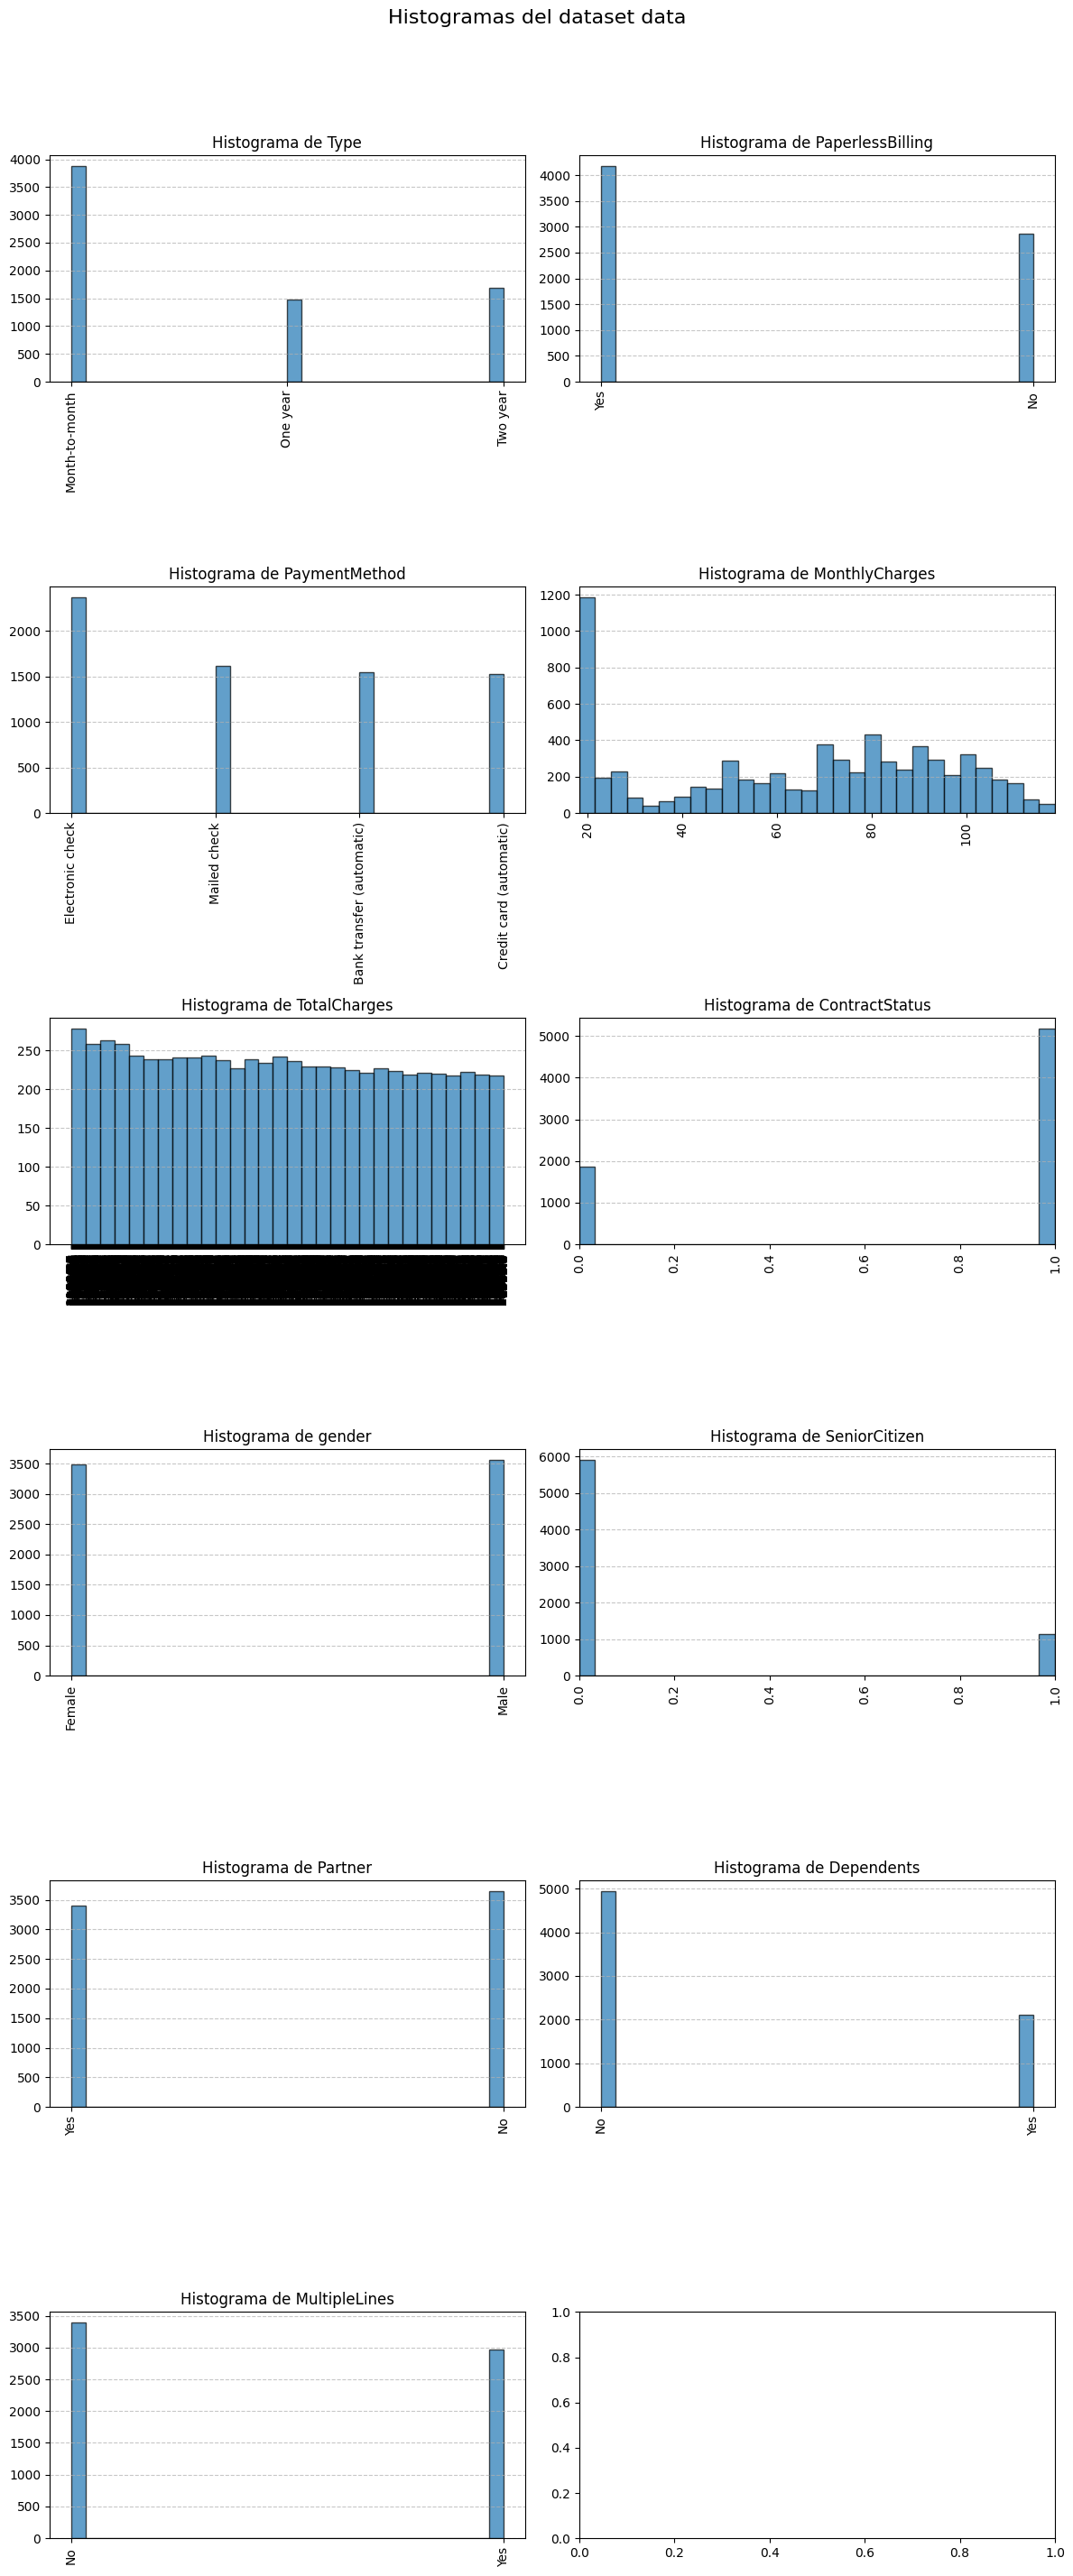

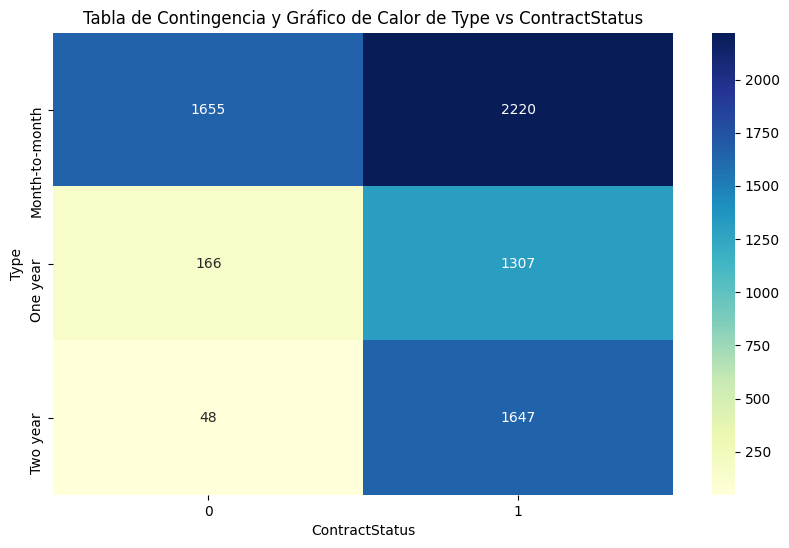

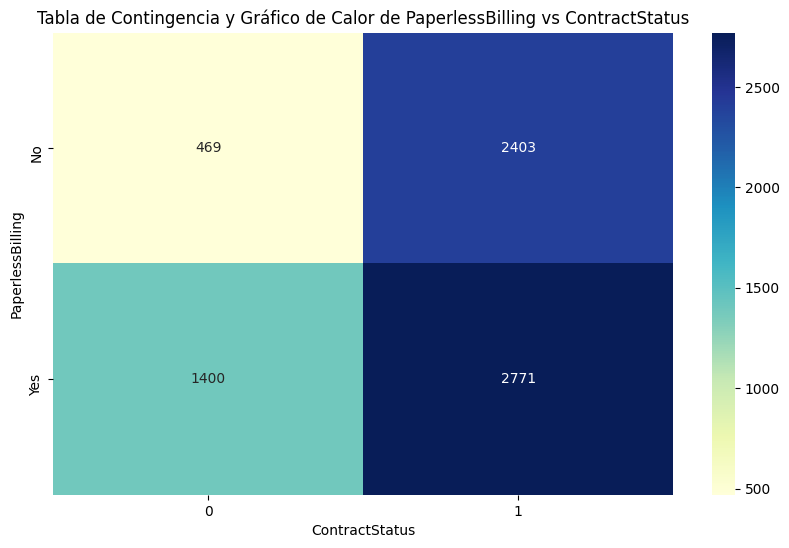

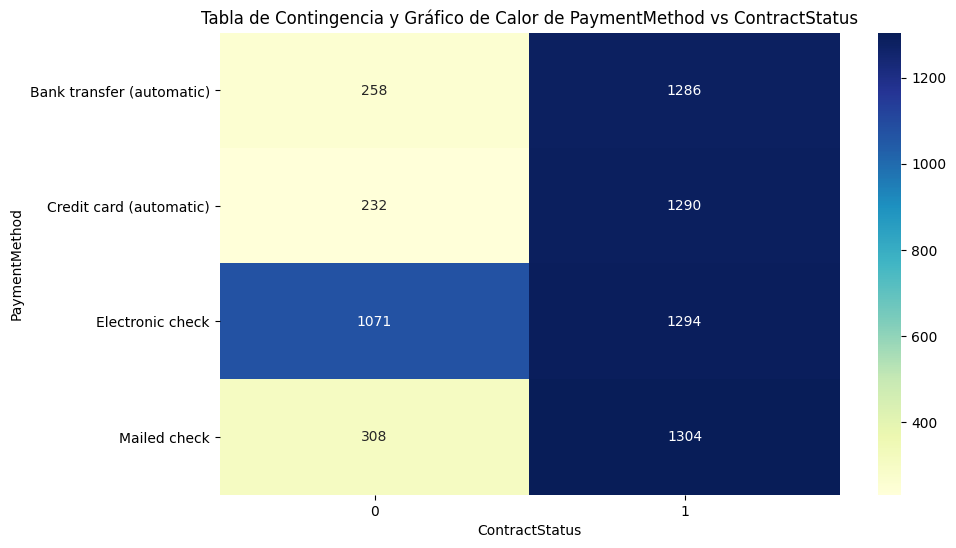

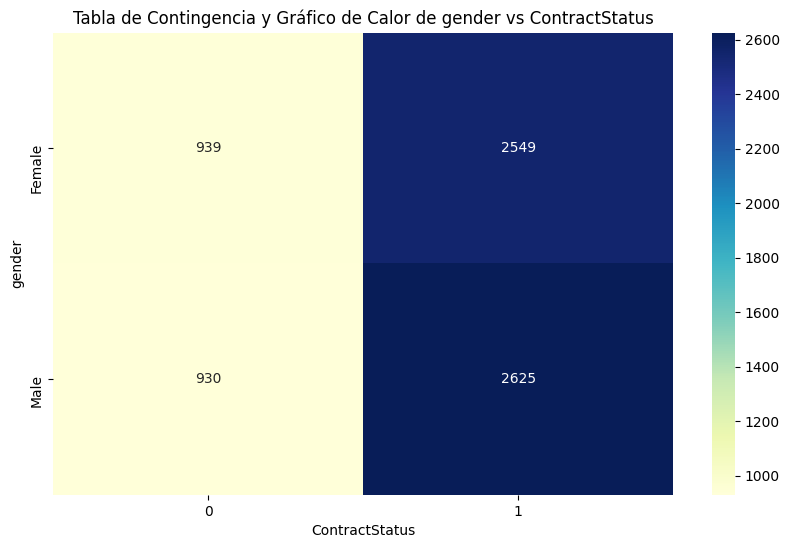

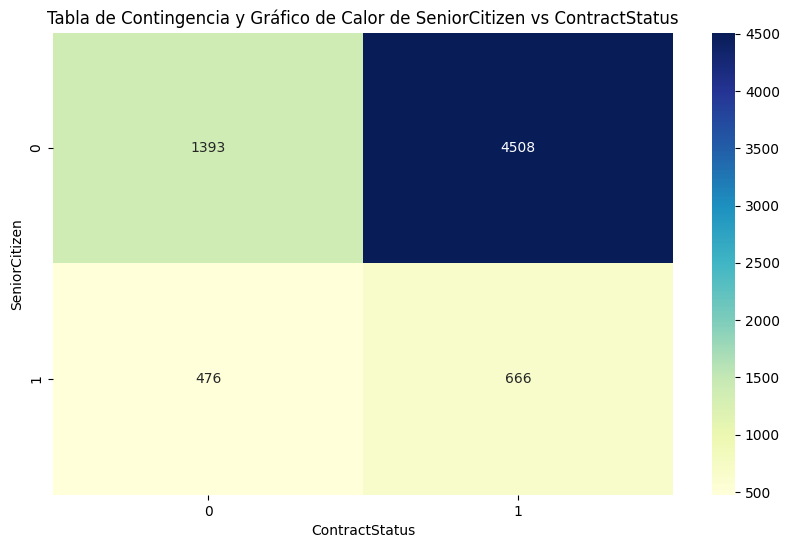

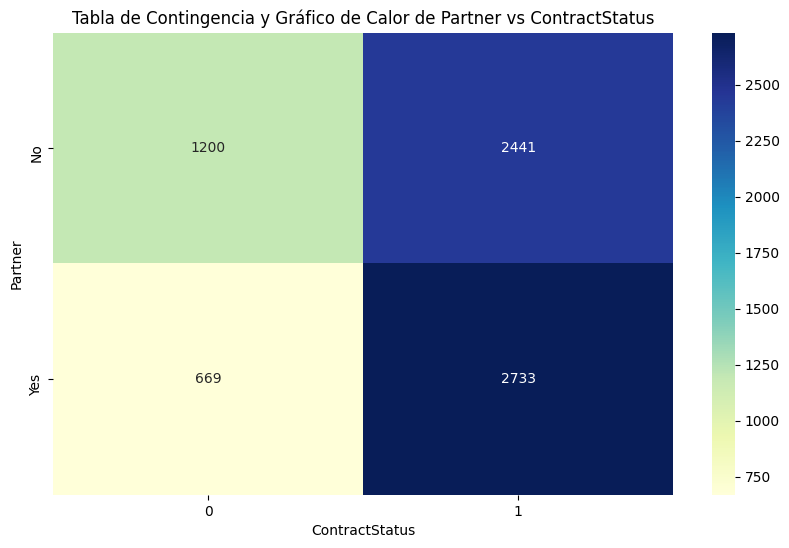

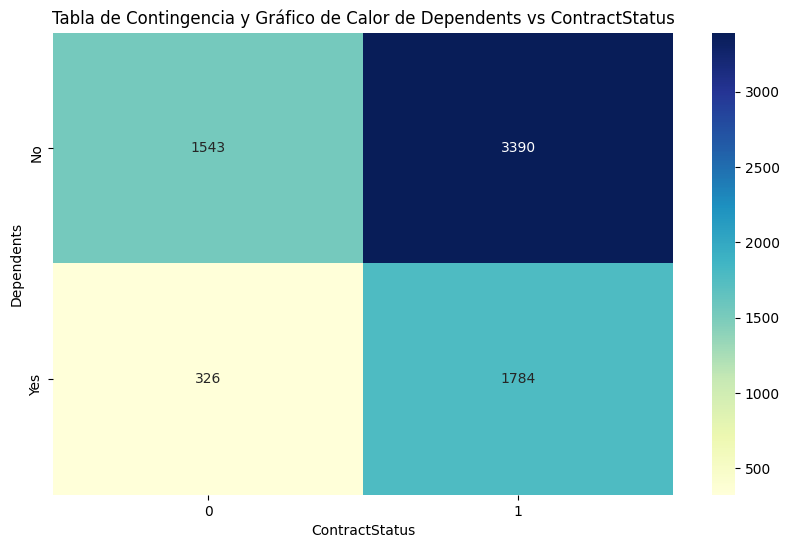

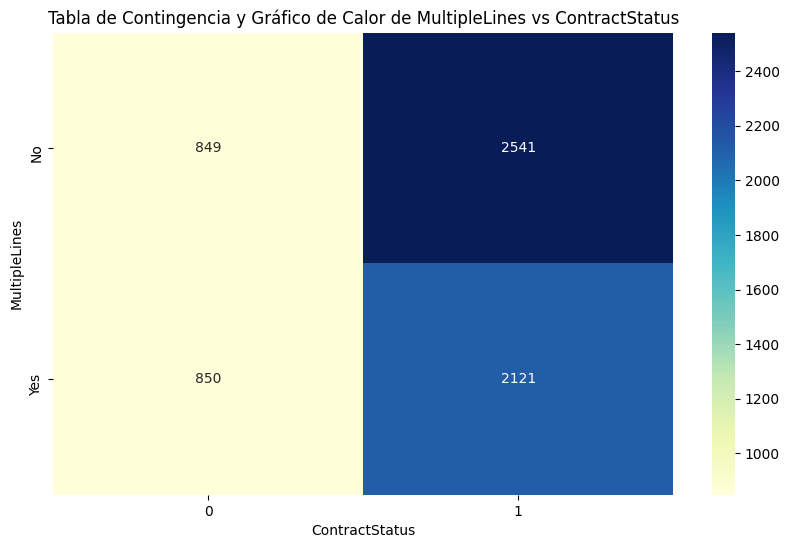

KeyError: 'mb_used'

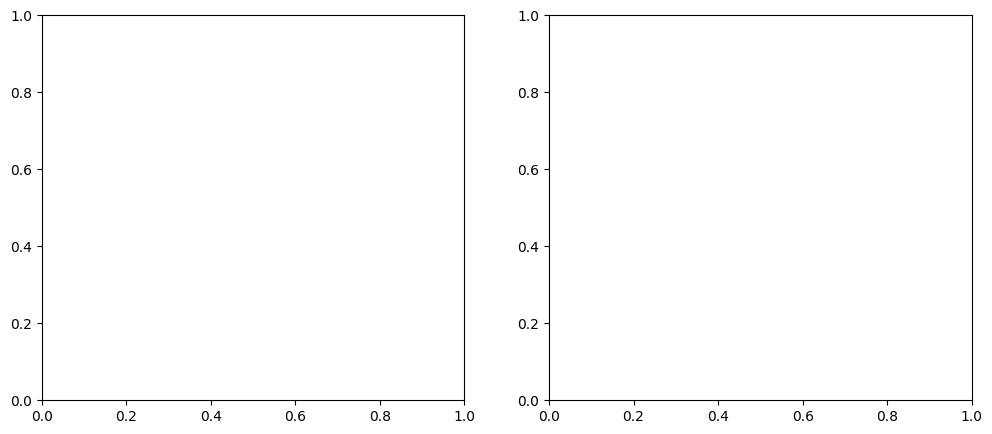

In [38]:
# Definimos la función para visualizar histogramas
def visualize_histograms(df, columns, title):
    n = len(columns)
    rows = (n + 1) // 2
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(12, 5 * rows))
    axes = axes.flatten()
    for i, column in enumerate(columns):
        axes[i].hist(df[column].dropna(), bins=30, alpha=0.7, edgecolor='black')  # Añadir borde negro a las barras
        axes[i].set_title(f'Histograma de {column}')
        
        # Aseguramos de que los valores sean numéricos
        if pd.api.types.is_numeric_dtype(df[column]):
            axes[i].set_xlim(left=df[column].dropna().min(), right=df[column].dropna().max())
        
        # Ajustamos los ticks del eje x para mejor visibilidad
        axes[i].tick_params(axis='x', labelsize=10)  # Ajusta el tamaño de las etiquetas del eje x
        axes[i].tick_params(axis='y', labelsize=10)  # Ajusta el tamaño de las etiquetas del eje y
        
    
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)
        
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    
# Función para crear tablas de contingencia y gráficos de calor
def visualize_contingency_heatmap(df, categorical_columns, target_column, title):
    for column in categorical_columns:
        contingency_table = pd.crosstab(df[column], df[target_column])
        plt.figure(figsize=(10, 6))
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
        plt.title(f'Tabla de Contingencia y Gráfico de Calor de {column} vs {target_column}')
        plt.show()    

# Dataset completo 'data'
columns_data = data.drop(columns=['customerID', 'BeginDate', 'EndDate']).columns
visualize_histograms(data, columns_data, 'Histogramas del dataset data')

# Excluyendo las columnas 'MonthlyChanges' y 'TotalChanges' para la visualización del mapa de calor contra la variable objetivo.
heatmap_columns = [col for col in columns_data if col not in ['MonthlyCharges', 'TotalCharges', 'ContractStatus']]
visualize_contingency_heatmap(data, heatmap_columns, 'ContractStatus', 'Tablas de Contingencia del dataset data')


# Dataset internet
columns_internet = ['mb_used']
visualize_histograms(internet, columns_internet, 'Histogramas del dataset internet')


**Con el análisis exploratorio de datos (EDA) podemos concluir lo siguiente:**

- Todos los datasets no tienen valores ausentes.
- No hay duplicidad de datos en los datasets.
- El dataset 'contract' no tiene valores anómalos, aunque se observan solo 11 fechas de inicio del '2020-02-01', el cual indica la fecha en que la información del contrato es valida. Al parecer son muy bajos datos.
- El dataset 'personal' tiene no tiene valores anómalos.
- El dataset 'internet' tiene valores anómalos: entre ellos la variable 'Unnamed:0' porque es una variable de indice, es decir, sobra. Por otro lado, este dataset no tiene un 'customerID' por lo que no se podrá conectar con los demás datasets. Además, tiene información de sobra para el modelo como 'id' y 'user_id'.
- El dataset 'phone' no tiene anomalías.
- Los tipos de datos son correctos para cada variable en todos los datasets, excepto aquellos que tienen variables de fecha. Debiese cambiar de 'object' a 'datetime'.
- Los nombres de las columnas es recomendable que estén en minuscula.

**Respecto a la distribución de los datos en del dataset completo:**
* En la variable 'Type', 'Month-to-month' tiene mayor frecuencia que las demás, por lo que podría ocasionar distorsion en el modelo.
* Las variables PaperlessBilling y  PaymentMethod tienen una distribucion relativamente homogenea, excepto el pago por medio de cheque electrónico (electronic check), el cual tiene mayor preferencia.
* En el cargo mensual, se puede apreciar un pago mucho más frecuente entre los 0 a 20 dolares mensuales. Esto puede marcar diferencia en el modelo predictivo.
* Si vemos los cargos totales, la distribución pasa a ser homogenea en todos sus rangos.
* Podemos ver en la variable objetivo 'ContractStatus' que el valor 1 tiene mas frecuencia (5000) con respecto al valor 0 (poco menos de 2000 casos), es decir, la mayoría de contratos no han sido cancelados.
* En relacion al genero, no se ven una tendencia clara, lo cual puede ser irrelevante para el modelo y respecto a si son mayores de edad (SeniorCitizen) se puede ver que una minoría lo es..
* Respecto a si tienen pareja o no, este no hay una tendencia clara, pero respecto a si tiene dependientes en su familia sólo 2/7 lo tienen.
* Respecto al dataset 'internet' se ve que hubo más casos de usuarios que usaron megas más bajos.

**Respecto a la correlacion con la variable objetivo (categorica) sobre el término de contrato:**

* El término de contrato se da más en los contratos mensuales, no de largo plazo.
* Si hay facturacion electrónica hay mas casos de termino de contrato.
* El término se da más por el metodo de pago 'electronic check'.
* Se ve una leve tendencia al termino de contrato si no son 'senior citizen'.
* Los que no tienen dependientes ni pareja suelen terminar sus contratos.
* No se ve tendencia si el servicio tiene múltiples lineas.

**PREGUNTAS ACLARATORIAS**

1) El enunciado del proyecto dice que la información de los contratos cuenta a partir del '2020-02-01' pero analizando los datos solo 11 contratos inician en esa fecha. ¿Hay un error en el dataset 'contract' o el enunciado quiere decir otra cosa?

2) El dataset 'internet' no tiene el 'customerID' por lo que no puedo enlazar su información con los demas datasets.

3) ¿Será oportuno calcular la duración de los contratos (valor duracion en meses o dias) y el tiempo restante del contrato (fecha inicio hasta 'no')? De ser así, ¿como podria dejar esa columna de duracion de contrato, es decir, con valores numéricos y una categoria de 'vigente' en una columna? 

4) ¿Que quiere decir exactamente la variable 'session_date' del dataset 'internet'? ¿Debiese además haber una variable de tiempo para poder obtener el uso promedio de 'mb' por mes?

5) El enunciado del proyecto habla de que Interconnect proporciona otros tipos de servicios, como: Seguridad en Internet y un bloqueador de sitios web maliciosos, una línea de soporte técnico, almacenamiento de archivos en la nube y backup de datos, y finalmente, Streaming de TV y directorio de películas, pero estos servicios no aparecen en los dataset entregados. ¿efectivamente falta algun otro dataset?.

6) ¿Para el modelo debiese trabajar con el cobro mensual o cobro total? ¿Debería usar solo uno, no ambos, cierto?


**PASOS A SEGUIR PARA RESOLVER LA TAREA**

1) Una vez realizado el análisis exploratorio de datos, debiese pasar a la etapa de 'Preparación de datos' según las conclusiones obtenidas de ese análisis. Esto incluye: ajuste de nombres en minusculas, tipo de datos de fechas, unificar datasets(debe incluir la informacion faltante de los servicios extras ademas de telefonia e internet), conversión de variables categóricas en numéricas para realizar el modelo, normalizar las variables numéricas, examinar equilibrio de clases.

2) Dado que el objetivo es predecir una variable binaria (cancelación o no cancelación), se usarán modelos de clasificación supervisada, donde inicialmente se entrenará y evaluará el modelo de regresión lineal para tener un análisis base.

3) Luego, seleccionamos el modelo más optimo basado en las métricas de evaluación como precision, recall, f1-score y AUC-ROC e hiperparámetros a través de métodos iterativos. Modelos pueden ser: Árboles de Decisión y Random Forest, o modelos más complejos con alto rendimiento como Gradient Boosting Machines (GBM) y XGBoost.
